In [957]:
## Packages
# system
import os
import math
# data wrangling
import numpy as np
import pandas as pd
from scipy import stats
from dfply import *
import statistics
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, make_scorer, accuracy_score, balanced_accuracy_score, f1_score, precision_score, roc_auc_score
from sklearn.preprocessing import normalize, StandardScaler
## Settings
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', 1000)

## Data Import

In [1057]:
df = pd.read_csv('../processed_data/provider_final_new.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('Provider')
display(df.shape)
df.head(3)

(5410, 46)

,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,Serves,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP,SharePhysician,MergeAvgClaimReimbursed,NumTopCodeClaim,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,No,4.0000,5.0000,0.0000,0.5500,Both,6.0000,5.7600,5.0000,79.0000,77.8800,5.0000,19.0000,1.0000,1.0000,1.0000,4185.6000,5.0000,0.0000,0.0000,no,0.0000,no,0.0000,no,0.0000,no,11.0000,0.5500,yes,50.0000,yes,422.0000,yes,278.0000,yes,1.4400,24,25,1.0400,109980,4582.5000,0,2,23,1.0900
PRV51003,Yes,4.0000,5.1613,0.0000,2.3571,Both,7.0000,6.6742,6.0000,71.0000,69.0833,53.0000,66.0000,3.0000,3.0000,1.0000,4588.4091,25.0000,1.0000,0.0161,yes,2.0000,yes,2.0000,yes,2.0000,yes,25.0000,0.3571,yes,52.0000,yes,1351.0000,yes,372.0000,yes,3.6700,117,132,1.1300,671956,5743.2100,0,4,93,1.1900
PRV51004,No,0.0000,0.0000,0.0000,1.4295,OP,7.0000,6.8121,8.0000,72.0000,71.2617,0.0000,138.0000,0.0000,9.0000,1.0000,350.1342,5.0000,0.0000,0.0000,no,0.0000,no,0.0000,no,0.0000,no,72.0000,0.4832,yes,52.0000,yes,3006.0000,yes,375.0000,yes,1.4300,138,149,1.0800,52480,380.2900,0,12,149,1.2700


## Exclude columns

In [1058]:
# display(df.columns[df.columns.str.contains('DupClaim')])
# del_col = ['DupClaim_IP','DupClaim_OP','DupClaimRatio_IP','DupClaimRatio_OP',
#            'DupClaimMultiState_IP','DupClaimMultiState_OP','DupClaimMultiProvider_IP','DupClaimMultiProvider_OP',
#           'DupClaimMultiStartDt_IP','DupClaimMultiStartDt_OP']

In [1059]:
# print('before delete cols', df.shape)
# df_num = df.drop(del_col, axis=1)
# print('after delete cols', df_num.shape)

## dummy variables

In [1060]:
# Make dummies
encode_cols = df[~df.applymap(np.isreal)].dropna(axis=1).columns.to_list()
print(encode_cols)
df[encode_cols[2:]] = df[encode_cols[2:]].applymap(lambda x: 1 if x.lower() == 'yes' else 0)
dummies = pd.get_dummies(df['Serves'],prefix='Serves_',drop_first=True)
df_dum = pd.concat([df.drop('Serves',axis=1),dummies],axis=1)
df_dum.shape

['PotentialFraud', 'Serves', 'DupClaim_IP', 'DupClaimMultiState_IP', 'DupClaimMultiProvider_IP', 'DupClaimMultiStartDt_IP', 'DupClaim_OP', 'DupClaimMultiState_OP', 'DupClaimMultiProvider_OP', 'DupClaimMultiStartDt_OP']


(5410, 47)

#### convert potential fraud flag to 1 & 0

In [1061]:
# this is for pos_label for precision & recall for gridsearchcv
df_dum['PotentialFraud'] = np.where(df_num_dum['PotentialFraud']=='Yes', 1, 0)
df_dum['PotentialFraud'] = np.where(df_num_dum['PotentialFraud']=='Yes', 1, 0)

#### normalization 

In [632]:
# normalize_cols = df[df.applymap(np.isreal)].dropna(axis=1).columns.to_list()
# df_norm_part = pd.DataFrame(normalize(df[normalize_cols]), columns=normalize_cols, index=df.index)
# df_norm_part.head(2)

,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP,SharePhysician,MergeAvgClaimReimbursed,NumTopCodeClaim,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,0.000036,0.000045,0.0,0.000005,0.000054,0.000052,0.000045,0.000717,0.000707,0.000045,0.000172,0.000009,0.000009,0.000009,0.037997,0.000045,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000100,4.992909e-06,0.000009,0.000454,0.000009,0.003831,0.000009,0.002524,0.000009,0.000013,0.000218,0.000227,0.000009,0.998400,0.041600,0.0,0.000018,0.000209,0.000010
PRV51003,0.000006,0.000008,0.0,0.000004,0.000010,0.000010,0.000009,0.000106,0.000103,0.000079,0.000098,0.000004,0.000004,0.000001,0.006828,0.000037,0.000001,2.400162e-08,0.000001,0.000003,0.000001,0.000003,0.000001,0.000003,0.000001,0.000037,5.314644e-07,0.000001,0.000077,0.000001,0.002010,0.000001,0.000554,0.000001,0.000005,0.000174,0.000196,0.000002,0.999938,0.008546,0.0,0.000006,0.000138,0.000002


In [575]:
# df_dum.drop(df_dum[normalize_cols], axis = 1, inplace = True)

In [578]:
# df_dum_norm = df_dum.merge(df_norm_part, left_index=True, right_index=True)
# df_dum_norm.shape

(5410, 47)

In [181]:
# def make_dummy_df(df, cols) :
#     for x in cols:
#         dums = pd.get_dummies(df[x], drop_first=True, prefix=x)
#         df = pd.concat((df, dums), axis=1)
#         df.drop([x], axis=1, inplace=True)
#     return df

In [262]:
# # dummy_list_1 = ['Serves'] # for df_num
# dummy_list_2 = ['Serves','DupClaim_IP','DupClaim_OP','DupClaimRatio_IP','DupClaimRatio_OP',
#            'DupClaimMultiState_IP','DupClaimMultiState_OP','DupClaimMultiProvider_IP','DupClaimMultiProvider_OP',
#           'DupClaimMultiStartDt_IP','DupClaimMultiStartDt_OP'] # for df

In [251]:
# # df_num_dum = make_dummy_df(df_num, dummy_list_1)
# df_dum = make_dummy_df(df, dummy_list_2)
# display(df_dum.shape)
# foo = make_dummy_df(df, encode_cols)
# display(foo.shape)

(5410, 1598)

(5410, 47)

In [187]:
# display(df_dum.head(2))
# display(df_num_dum.head(2))

## split train-test

In [1062]:
x = df_dum.drop(['PotentialFraud'], axis = 1)
y = df_dum.PotentialFraud
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [1063]:
# for flag 1,0
print('ytrain class ave', ytrain.mean())
print('ytest class ave', ytest.mean())

print(x.shape)
print(xtrain.shape)
print(xtest.shape)

ytrain class ave 0.09357670979667283
ytest class ave 0.0933456561922366
(5410, 46)
(4328, 46)
(1082, 46)


## Logistic Regression

#### normalization / standardization

In [1064]:
ss = StandardScaler()
ss.fit(xtrain)
xstrain = ss.transform(xtrain)

In [789]:
# recall of positive - sensitivity; recall of negative - specificity
lr = LogisticRegression(class_weight='balanced') # create fake positive/negative to balance

# lr_params = [{'penalty': ['l1'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 'solver':['liblinear']}] 
              #'max_iter':[1000]}] # l1=lasso

lr_params = [{'penalty': ['l1', 'l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 'solver':['liblinear']}] 
    
# lr_params = [{'penalty': ['l1', 'l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100,1000], 
#               'max_iter':[1000], 'solver':['liblinear']}, 
#              {'penalty': ['elasticnet'], "C":[0.0001,0.001,0.01,0.1,1,10,100,1000], 
#               'max_iter':[1000], 'solver':['liblinear'], 'l1_ratio':[0.2, 0.4, 0.6, 0.8]}] # l1=lasso

# kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# average: use binary instead of weighted because already have class_weight = balanced in rf, also it's a binary, weighted is more about multiclass; for evaluation don't want to weighted based on proportion  

scores = {'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'), 
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(balanced_accuracy_score),
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')}

# scores = ['f1_weighted', 'recall', 'precision', 'accuracy']

lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
                       cv = 5, verbose=2, scoring=scores, refit=False, n_jobs=-1)

# lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
#                        cv = 5, verbose=2, scoring='recall', refit=True, n_jobs=-1)

%time lr_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s


CPU times: user 664 ms, sys: 253 ms, total: 917 ms
Wall time: 7.11 s


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    7.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0...
             scoring={'accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(precision_score, pos_label=1, average=binary),
                      'recall': make_scorer(

In [790]:
# best model
# display(lr_grid.best_params_)
# print('lr best validation score', lr_grid.best_score_)
# print('lr best train score', lr_grid.score(xtrain, ytrain))

In [791]:
keys = list(lr_grid.cv_results_.keys())
mean_test = [s for s in keys if 'mean_test' in s]
mean_train = [s for s in keys if 'mean_train' in s]
print(mean_test)
print(mean_train)

['mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_specificity', 'mean_test_roc_auc_score']
['mean_train_recall', 'mean_train_f1', 'mean_train_precision', 'mean_train_accuracy', 'mean_train_specificity', 'mean_train_roc_auc_score']


In [816]:
lr_grid_scores = pd.DataFrame({'params': lr_grid.cv_results_['params'], 
              'mean_test_recall': lr_grid.cv_results_['mean_test_recall'],
              'mean_train_recall': lr_grid.cv_results_['mean_train_recall'],
              'mean_test_f1': lr_grid.cv_results_['mean_test_f1'],
              'mean_train_f1': lr_grid.cv_results_['mean_train_f1'],
              'mean_test_precision': lr_grid.cv_results_['mean_test_precision'],
              'mean_train_precision': lr_grid.cv_results_['mean_train_precision'],
              'mean_test_accuracy': lr_grid.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': lr_grid.cv_results_['mean_train_accuracy'],
              'mean_test_specificity': lr_grid.cv_results_['mean_test_specificity'],
              'mean_train_specificity': lr_grid.cv_results_['mean_train_specificity'],
              'mean_test_roc_auc_score': lr_grid.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': lr_grid.cv_results_['mean_train_roc_auc_score']
             })

# lr_grid_scores.to_csv('../output/lr_grid_scores_l1.csv')
# lr_grid_scores.to_csv('../output/lr_grid_scores_l1l2.csv')
# lr_grid_scores.to_csv('../output/lr_grid_scores_l1l2en.csv')
lr_grid_scores.head(1)

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1,mean_test_precision,mean_train_precision,mean_test_accuracy,mean_train_accuracy,mean_test_specificity,mean_train_specificity,mean_test_roc_auc_score,mean_train_roc_auc_score
0,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.807407,0.814198,0.567463,0.572753,0.438202,0.441843,0.850301,0.85395,0.893194,0.893703,0.850301,0.85395


In [793]:
# never split data into T/F and handle them differently
# L2 is more flexible because it is smooth function, L1 is not a smooth function
# elasticnet may keep need to use the solver that works for L1, because L2 is more flexbile
# preceision expected to be 90-95%
# can change the threshold of probabilty

In [794]:
# np.logspace(-4, 4, 20)

### plots of scores

In [795]:
lr_grid_scores_test = lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('test')]]
display(lr_grid_scores_test.head(2))
lr_grid_scores_train = lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('train')]]
display(lr_grid_scores_train.head(2))

,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy,mean_test_specificity,mean_test_roc_auc_score
0,0.807407,0.567463,0.438202,0.850301,0.893194,0.850301
1,0.814815,0.575483,0.445281,0.855026,0.895237,0.855026


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.814198,0.572753,0.441843,0.853950,0.893703,0.853950
1,0.815432,0.574293,0.443374,0.854791,0.894149,0.854791


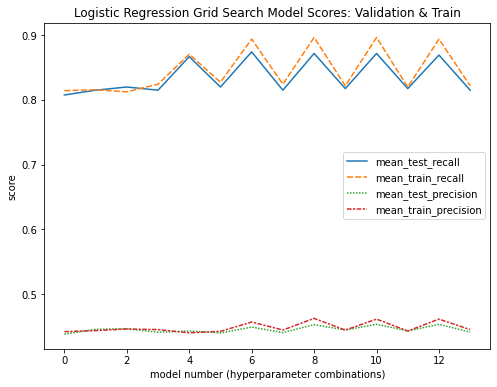

In [895]:
plt.figure(figsize=(8,6))
sns.lineplot(data =lr_grid_scores[['mean_test_recall','mean_train_recall',
                                   'mean_test_precision','mean_train_precision']])
plt.legend(loc=5)#bbox_to_anchor=(1.05,1),
# plt.xlim(0,10)
# plt.xticks(np.arange(0,10,1))
plt.xlabel('model number (hyperparameter combinations)')
plt.ylabel('score')
plt.title('Logistic Regression Grid Search Model Scores: Validation & Train')
plt.savefig('../output/lr_gridsearch_scores_l1l2_validation_train_4score.png', bbox_inches='tight')

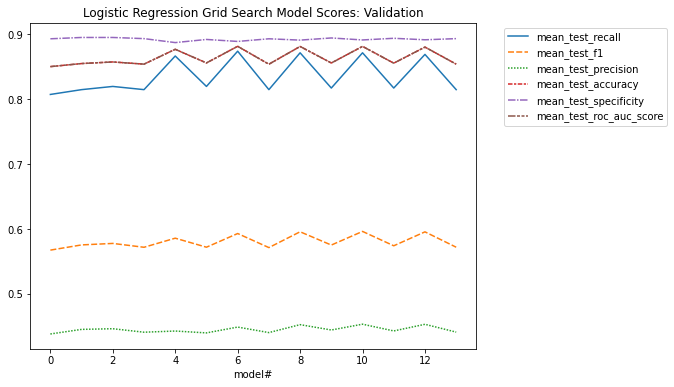

In [822]:
plt.figure(figsize=(8,6))
sns.lineplot(data =lr_grid_scores_test)
# sns.lineplot(data =lr_grid_scores[['mean_test_recall','mean_train_recall','mean_test_precision','mean_train_precision']])
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.xlim(0,10)
# plt.xticks(np.arange(0,10,1))
plt.xlabel('model#')
plt.title('Logistic Regression Grid Search Model Scores: Validation')
# plt.savefig('../output/lr_gridsearch_scores_l1_test.png', bbox_inches='tight')
plt.savefig('../output/lr_gridsearch_scores_l1l2_test.png', bbox_inches='tight')
# plt.savefig('../output/lr_gridsearch_scores_l1l2en_test.png', bbox_inches='tight')

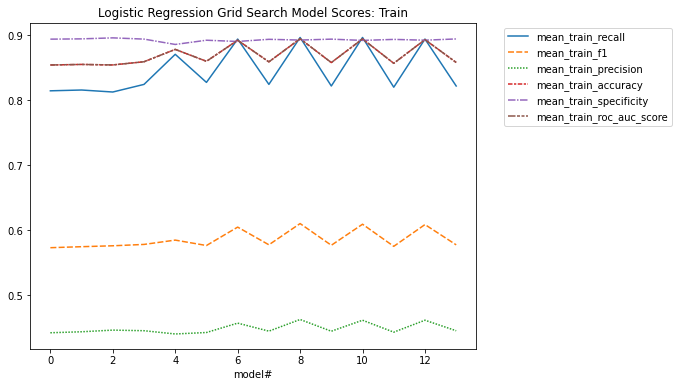

In [797]:
plt.figure(figsize=(8,6))
sns.lineplot(data =lr_grid_scores_train)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xlabel('model#')
plt.title('Logistic Regression Grid Search Model Scores: Train')
# plt.savefig('../output/lr_gridsearch_scores_l1_train.png', bbox_inches='tight')
plt.savefig('../output/lr_gridsearch_scores_l1l2_train.png', bbox_inches='tight')
# plt.savefig('../output/lr_gridsearch_scores_l1l2en_train.png', bbox_inches='tight')

### best LR model

In [798]:
best_row = lr_grid_scores.mean_test_recall.idxmax()
worst_row = lr_grid_scores.mean_test_recall.idxmin()
print('best lr row number', best_row)
print('worst lr row number', worst_row)
# print('best lr', lr_grid_scores.params[best_row], 'mean_test_recall', round(lr_grid_scores.mean_test_recall[best_row], 4))
print('best lr', lr_grid_scores.params[best_row])
display(lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('mean_test')]].iloc[[best_row,]])
display(lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('mean_train')]].iloc[[best_row,]])

best lr row number 6
worst lr row number 0
best lr {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy,mean_test_specificity,mean_test_roc_auc_score
6,0.874074,0.593028,0.448837,0.881593,0.889113,0.881593


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
6,0.893827,0.604445,0.456662,0.891981,0.890135,0.891981


In [758]:
# lr = LogisticRegression(random_state=4, class_weight='balanced')
# lr_params = [{'penalty': ['l1'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 
#               'max_iter':[1000], 'solver':['liblinear']}] # l1=lasso
# lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
#                        cv = 5, verbose=2, scoring='recall', refit=True, n_jobs=-1)
# %time lr_grid.fit(xtrain, ytrain)

In [759]:
# logreg3 = LogisticRegression(class_weight='balanced', solver = 'liblinear')
# grid_logreg3 = {'penalty':['l1'], 
#               'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

# grid_search_logreg3 = GridSearchCV(logreg3, grid_logreg3, scoring='recall', cv=5, n_jobs=-1)
# %time grid_search_logreg3.fit(xtrain, ytrain)

In [732]:
# lr_grid.best_estimator_
grid_search_logreg3.best_estimator_

LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [1065]:
lr_best = LogisticRegression(penalty='l1', C=0.01, solver='liblinear')
lr_best.fit(xtrain, ytrain)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

,0,1
0,3874,49
1,209,196


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3923
           1       0.80      0.48      0.60       405

    accuracy                           0.94      4328
   macro avg       0.87      0.74      0.79      4328
weighted avg       0.93      0.94      0.93      4328



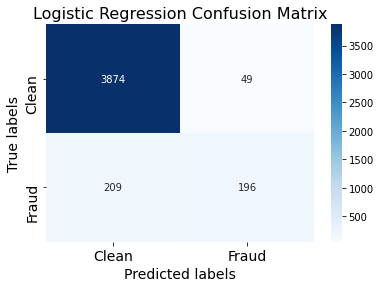

In [1072]:
# confusion matrix
ypred = lr_best.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

# recall = recall_score(ytrain.array, ypred, average='binary', pos_label=0) # sensitivity
# print('recall:', round(recall, ndigits=5))
# precision = lr_grid.best_estimator_.score(xtrain, ytrain) # precision
# print('precision:', round(precision, ndigits=4))
# accuracy = accuracy_score(ytrain.array, ypred) # accuracy
# print('accuracy', round(accuracy, 4))

from sklearn.metrics import classification_report
print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Logistic Regression Confusion Matrix', fontsize=16)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
plt.savefig('../output/lr_cm_heatmap_1.png')

In [1071]:
# # yes is pos
# print(367/(367+45))
# # no is pos
# print(3498/(3498+418))
# print(3061/(3061+369))
# print(3498/(3498+418))

## Random Forest

#### train test split

In [909]:
df_dum.drop(['DurationMedianIP'], axis=1, inplace=True)

In [910]:
x = df_dum.drop(['PotentialFraud'], axis = 1)
y = df_dum.PotentialFraud
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=4, stratify=y)

In [911]:
rf = RandomForestClassifier(random_state=4, oob_score=True, class_weight='balanced')

In [912]:
print('num of observations', xtrain.shape[0])
print('num of features', xtrain.shape[1])
# print('min_samples_leaf', list(np.arange(2,11,2))) # more computationally expensive than min_split, but control
# print('max_depth', list(np.arange(1,36,11)))

max_features_1 = np.arange(2,int(xtrain.shape[1]/2),4)
print('max_features', max_features_1)
min_split_1 = np.arange(5,21,5)
print('min_samples_split', min_split_1) # use one, min_leaf & min_split are smiliar

num of observations 4328
num of features 45
max_features [ 2  6 10 14 18]
min_samples_split [ 5 10 15 20]


In [913]:
rf_params = [{'max_features': max_features_1,'n_estimators': [200, 500],
             'min_samples_split': min_split_1}]

kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'), # use binary not weighted
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(accuracy_score), # not use balanced_accurarcy_score
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')
         }


rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, return_train_score=True, 
                       cv = kf5, verbose=2, scoring=scores, refit=False)

%time rf_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.2s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_split=5, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=500, total=   2.8s
[CV] max_features=2, min_samples_split=5, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=500, total=   2.4s
[CV] max_features=2, min_samples_split=5, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=500, total=   2.6s
[CV] max_features=2, min_samples_split=5, n_estim

[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   3.8s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   4.0s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   3.9s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.6s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.4s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.4s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.4s
[CV] max_features=6, min_samples_split=15,

[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   1.8s
[CV] max_features=10, min_samples_split=20, n_estimators=200 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   1.6s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.1s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.8s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   5.9s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.8s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.6s
[CV] max_features=14, min_samples_s

[CV]  max_features=18, min_samples_split=5, n_estimators=500, total=  11.6s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   4.4s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   4.1s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   3.5s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   3.5s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   3.4s
[CV] max_features=18, min_samples_split=10, n_estimators=500 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=500, total=   7.5s
[CV] max_features=18, min_samples_sp

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 12.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=...
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(p

In [914]:
keys = list(rf_grid.cv_results_.keys())
mean_test = [s for s in keys if 'mean_test' in s]
mean_train = [s for s in keys if 'mean_train' in s]
print(mean_test)
print(mean_train)

['mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_specificity', 'mean_test_roc_auc_score']
['mean_train_recall', 'mean_train_f1', 'mean_train_precision', 'mean_train_accuracy', 'mean_train_specificity', 'mean_train_roc_auc_score']


In [915]:
rf_grid_scores = pd.DataFrame({'params': rf_grid.cv_results_['params'], 
              'mean_test_recall': rf_grid.cv_results_['mean_test_recall'],
              'mean_train_recall': rf_grid.cv_results_['mean_train_recall'],
              'mean_test_f1': rf_grid.cv_results_['mean_test_f1'],
              'mean_train_f1': rf_grid.cv_results_['mean_train_f1'],
              'mean_test_precision': rf_grid.cv_results_['mean_test_precision'],
              'mean_train_precision': rf_grid.cv_results_['mean_train_precision'],
              'mean_test_accuracy': rf_grid.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': rf_grid.cv_results_['mean_train_accuracy'],
              'mean_test_specificity': rf_grid.cv_results_['mean_test_specificity'],
              'mean_train_specificity': rf_grid.cv_results_['mean_train_specificity'], 
              'mean_test_roc_auc_score': rf_grid.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': rf_grid.cv_results_['mean_train_roc_auc_score']
             })
# rf_grid_scores.to_csv('../output/rf_grid_scores.csv')
# rf_grid_scores.iloc[:,1:]
rf_grid_scores.head(2)

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1,mean_test_precision,mean_train_precision,mean_test_accuracy,mean_train_accuracy,mean_test_specificity,mean_train_specificity,mean_test_roc_auc_score,mean_train_roc_auc_score
0,"{'max_features': 2, 'min_samples_split': 5, 'n...",0.540741,0.998765,0.605364,0.987189,0.689767,0.975889,0.934151,0.997574,0.974764,0.997451,0.757752,0.998108
1,"{'max_features': 2, 'min_samples_split': 5, 'n...",0.530864,1.000000,0.598091,0.986302,0.686679,0.972976,0.933226,0.997401,0.974763,0.997132,0.752814,0.998566


In [916]:
best_row = rf_grid_scores.mean_test_recall.idxmax()
worst_row = rf_grid_scores.mean_test_recall.idxmin()
print('best RF row number', best_row)
print('worst RF row number', worst_row)
# print('best RF', rf_grid_scores.params[best_row], 'mean_test_recall', round(rf_grid_scores.mean_test_recall[best_row], 4))
print('best RF', rf_grid_scores.params[best_row])
display(rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('mean_test')]].iloc[[best_row,]])
display(rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('mean_train')]].iloc[[best_row,]])
# print(rf_grid_scores.params[best_row+1], rf_grid_scores.mean_test_recall[best_row+1])
# print(rf_grid_scores.params[best_row-1], rf_grid_scores.mean_test_recall[best_row-1])
# print(rf_grid_scores.params[best_row+4], rf_grid_scores.mean_test_recall[best_row+4])

best RF row number 6
worst RF row number 32
best RF {'max_features': 2, 'min_samples_split': 20, 'n_estimators': 200}


,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy,mean_test_specificity,mean_test_roc_auc_score
6,0.874074,0.593028,0.448837,0.881593,0.889113,0.881593


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
6,0.893827,0.604445,0.456662,0.891981,0.890135,0.891981


In [917]:
# best RF model fit
rf_best_1 = RandomForestClassifier(oob_score=True, class_weight='balanced', 
                                  max_features=2, min_samples_split=20, n_estimators=200)
rf_best_1.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [1069]:
# confusion matrix
ypred = rf_best_1.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

# recall = recall_score(ytrain.array, ypred, average='binary', pos_label=0) # sensitivity
# print('recall:', round(recall, ndigits=5))
# precision = rf_grid.best_estimator_.score(xtrain, ytrain) # precision
# print('precision:', round(precision, ndigits=4))
# accuracy = accuracy_score(ytrain.array, ypred) # accuracy
# print('accuracy', round(accuracy, 4))

print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Random Forest Confusion Matrix', fontsize=16)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
# plt.savefig('../output/rf_fine_cm_heatmap_1.png')

ValueError: Number of features of the model must match the input. Model n_features is 45 and input n_features is 46 

In [1047]:
rf_feature_imp = pd.DataFrame(data = rf_best_1.feature_importances_, index=xtrain.columns, columns=['importance']).sort_values(by = 'importance', ascending=False)
# rf_feature_imp.plot(kind = 'bar')
rf_feature_imp.to_csv('../output/rf_final_features_importance.csv')
plt.figure(figsize=(8,6))
sns.barplot(y = rf_feature_imp.index[:10], x = 'importance', data = rf_feature_imp[:10],palette=sns.color_palette('Greens_d', n_colors=10)) #Greens_d
plt.title('Random Forest Feature Importance', fontsize=20)
plt.yticks(fontsize = 16)
# plt.savefig('../output/rf_final_feature_importance_green.png', bbox_inches='tight')
# plt.savefig('../output/rf_final_feature_importance_drop_median_green.png', bbox_inches='tight')

ValueError: Shape of passed values is (45, 1), indices imply (46, 1)

In [503]:
rf_grid_scores_test = rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('test')]]
display(rf_grid_scores_test.head(2))
rf_grid_scores_train = rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('train')]]
display(rf_grid_scores_train.head(2))

,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy,mean_test_specificity,mean_test_roc_auc_score
0,0.543210,0.611586,0.702490,0.935536,0.976037,0.759623
1,0.538272,0.611431,0.710441,0.935998,0.977057,0.757664


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.999383,0.984495,0.970047,0.997054,0.996814,0.998098
1,1.000000,0.985403,0.971229,0.997227,0.996941,0.998471


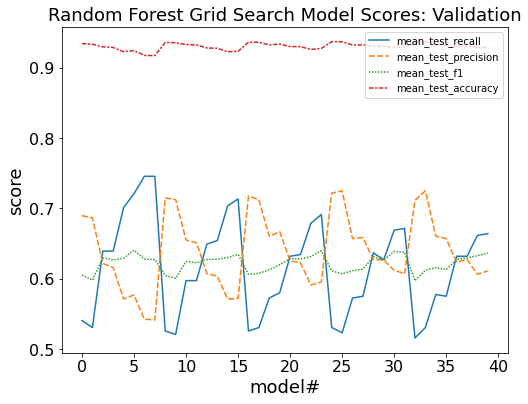

In [928]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores[['mean_test_recall','mean_test_precision','mean_test_f1',
                                   'mean_test_accuracy']])
plt.legend( loc=1) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Validation', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('../output/rf_gridsearch_scores_validation.png', bbox_inches='tight')
plt.savefig('../output/rf_gridsearch_scores_dropmedian_validation.png', bbox_inches='tight')

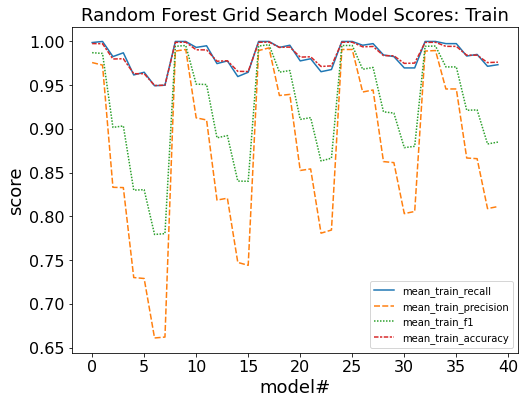

In [929]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores[['mean_train_recall','mean_train_precision', 'mean_train_f1','mean_train_accuracy']])
plt.legend(loc=4) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Train', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('../output/rf_gridsearch_scores_train.png', bbox_inches='tight')
plt.savefig('../output/rf_gridsearch_scores_dropmedian_train.png', bbox_inches='tight')

Text(0.5, 1.0, 'Random Forest Grid Search Model Scores: Test')

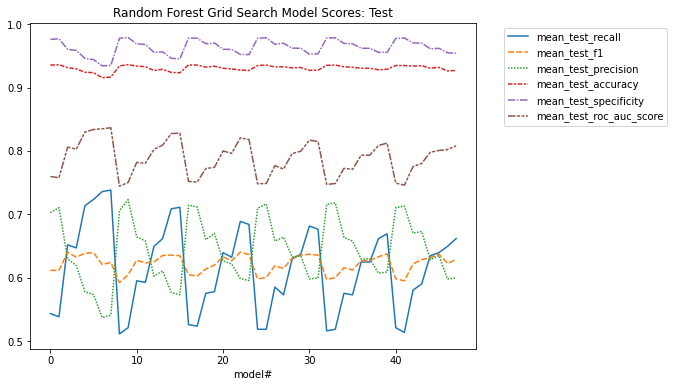

In [856]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_test)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.xlim(0,10)
# plt.xticks(np.arange(0,10,1))
plt.xlabel('model#')
plt.title('Random Forest Grid Search Model Scores: Validation')
# plt.savefig('../output/rf_gridsearch_scores_test4.png',, bbox_inches='tight')
# plt.savefig('../output/rf_gridsearch_scores_test_full.png', bbox_inches='tight')
# plt.savefig('../output/rf_gridsearch_scores_test_coarse.png', bbox_inches='tight')

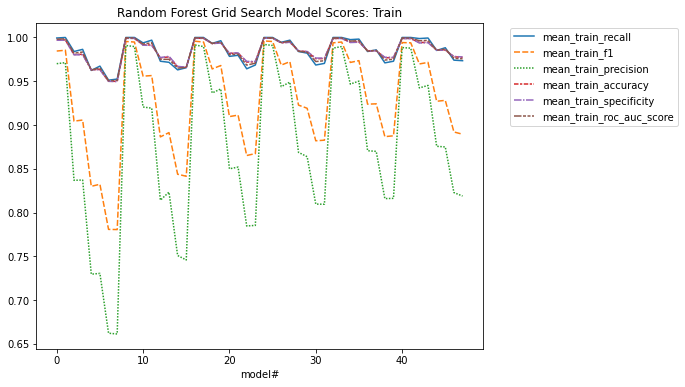

In [507]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_train)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xlabel('model#')
plt.title('Random Forest Grid Search Model Scores: Train')
# plt.savefig('../output/rf_gridsearch_scores_train4.png')
# plt.savefig('../output/rf_gridsearch_scores_train_full.png')

In [511]:
# second try
# display(rf_grid.best_estimator_)
# print('RF best validation score', rf_grid.best_score_)
# print('RF best train score', rf_grid.score(xtrain, ytrain))

In [512]:
# first try
# display(rf_grid.best_estimator_)
# print('RF best validation score', rf_grid.best_score_)
# print('RF best train score', rf_grid.score(xtrain, ytrain))

### finer gridsearch of random forest

In [930]:
max_features_2 = np.arange(1,5,1)
print('max_features', max_features_2)
# min_leaf = np.arange(2, 9, 1)
# display(min_leaf)
min_split_2 = np.arange(16, 25, 1)
print('min_split', min_split_2)
# estimators = [500, 1000]
estimators = [200,500] # drop median

max_features [1 2 3 4]
min_split [16 17 18 19 20 21 22 23 24]


In [931]:
rf_params = [{'max_features': max_features_2,'n_estimators': estimators,
             'min_samples_split': min_split}] # 'min_samples_leaf': min_leaf,

kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'),
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(accuracy_score), # use accuracy_score instead of balanced_accuracy_score
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')
         }


rf_grid_fine = GridSearchCV(estimator=rf, param_grid=rf_params, return_train_score=True, 
                       cv = kf5, verbose=2, scoring=scores, refit=False)

%time rf_grid_fine.fit(xtrain, ytrain)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] max_features=1, min_samples_split=6, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=1, min_samples_split=6, n_estimators=200, total=   0.9s
[CV] max_features=1, min_samples_split=6, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  max_features=1, min_samples_split=6, n_estimators=200, total=   0.8s
[CV] max_features=1, min_samples_split=6, n_estimators=200 ...........
[CV]  max_features=1, min_samples_split=6, n_estimators=200, total=   0.8s
[CV] max_features=1, min_samples_split=6, n_estimators=200 ...........
[CV]  max_features=1, min_samples_split=6, n_estimators=200, total=   1.1s
[CV] max_features=1, min_samples_split=6, n_estimators=200 ...........
[CV]  max_features=1, min_samples_split=6, n_estimators=200, total=   1.3s
[CV] max_features=1, min_samples_split=6, n_estimators=500 ...........
[CV]  max_features=1, min_samples_split=6, n_estimators=500, total=   2.4s
[CV] max_features=1, min_samples_split=6, n_estimators=500 ...........
[CV]  max_features=1, min_samples_split=6, n_estimators=500, total=   2.1s
[CV] max_features=1, min_samples_split=6, n_estimators=500 ...........
[CV]  max_features=1, min_samples_split=6, n_estimators=500, total=   2.1s
[CV] max_features=1, min_samples_split=6, n_estim

[CV]  max_features=1, min_samples_split=11, n_estimators=500, total=   2.4s
[CV] max_features=1, min_samples_split=11, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=11, n_estimators=500, total=   2.2s
[CV] max_features=1, min_samples_split=11, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=11, n_estimators=500, total=   1.9s
[CV] max_features=1, min_samples_split=12, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] max_features=1, min_samples_split=12, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] max_features=1, min_samples_split=12, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] max_features=1, min_samples_split=12, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] max_features=1, min_samples_split=12,

[CV]  max_features=2, min_samples_split=8, n_estimators=200, total=   1.2s
[CV] max_features=2, min_samples_split=8, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=8, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_split=8, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=8, n_estimators=500, total=   2.5s
[CV] max_features=2, min_samples_split=8, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=8, n_estimators=500, total=   2.5s
[CV] max_features=2, min_samples_split=8, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=8, n_estimators=500, total=   3.2s
[CV] max_features=2, min_samples_split=8, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=8, n_estimators=500, total=   2.7s
[CV] max_features=2, min_samples_split=8, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=8, n_estimators=500, total=   2.5s
[CV] max_features=2, min_samples_split=9, n_estim

[CV]  max_features=2, min_samples_split=13, n_estimators=500, total=   3.0s
[CV] max_features=2, min_samples_split=14, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_split=14, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_split=14, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_split=14, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_split=14, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=200, total=   1.2s
[CV] max_features=2, min_samples_split=14, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=500, total=   2.6s
[CV] max_features=2, min_samples_split=14,

[CV]  max_features=3, min_samples_split=10, n_estimators=500, total=   2.6s
[CV] max_features=3, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=10, n_estimators=500, total=   2.9s
[CV] max_features=3, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=10, n_estimators=500, total=   3.2s
[CV] max_features=3, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=10, n_estimators=500, total=   4.4s
[CV] max_features=3, min_samples_split=11, n_estimators=200 ..........
[CV]  max_features=3, min_samples_split=11, n_estimators=200, total=   1.1s
[CV] max_features=3, min_samples_split=11, n_estimators=200 ..........
[CV]  max_features=3, min_samples_split=11, n_estimators=200, total=   1.1s
[CV] max_features=3, min_samples_split=11, n_estimators=200 ..........
[CV]  max_features=3, min_samples_split=11, n_estimators=200, total=   1.2s
[CV] max_features=3, min_samples_split=11,

[CV]  max_features=4, min_samples_split=7, n_estimators=200, total=   1.1s
[CV] max_features=4, min_samples_split=7, n_estimators=200 ...........
[CV]  max_features=4, min_samples_split=7, n_estimators=200, total=   1.1s
[CV] max_features=4, min_samples_split=7, n_estimators=200 ...........
[CV]  max_features=4, min_samples_split=7, n_estimators=200, total=   1.1s
[CV] max_features=4, min_samples_split=7, n_estimators=500 ...........
[CV]  max_features=4, min_samples_split=7, n_estimators=500, total=   2.8s
[CV] max_features=4, min_samples_split=7, n_estimators=500 ...........
[CV]  max_features=4, min_samples_split=7, n_estimators=500, total=   2.7s
[CV] max_features=4, min_samples_split=7, n_estimators=500 ...........
[CV]  max_features=4, min_samples_split=7, n_estimators=500, total=   2.7s
[CV] max_features=4, min_samples_split=7, n_estimators=500 ...........
[CV]  max_features=4, min_samples_split=7, n_estimators=500, total=   2.9s
[CV] max_features=4, min_samples_split=7, n_estim

[CV]  max_features=4, min_samples_split=12, n_estimators=500, total=   2.8s
[CV] max_features=4, min_samples_split=12, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=12, n_estimators=500, total=   2.6s
[CV] max_features=4, min_samples_split=13, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=13, n_estimators=200, total=   1.0s
[CV] max_features=4, min_samples_split=13, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=13, n_estimators=200, total=   1.3s
[CV] max_features=4, min_samples_split=13, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=13, n_estimators=200, total=   1.3s
[CV] max_features=4, min_samples_split=13, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=13, n_estimators=200, total=   1.7s
[CV] max_features=4, min_samples_split=13, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=13, n_estimators=200, total=   1.4s
[CV] max_features=4, min_samples_split=13,

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 13.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=...
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(p

In [932]:
rf_grid_fine_scores = pd.DataFrame({'params': rf_grid_fine.cv_results_['params'], 
              'mean_test_recall': rf_grid_fine.cv_results_['mean_test_recall'],
              'mean_train_recall': rf_grid_fine.cv_results_['mean_train_recall'],
              'mean_test_f1': rf_grid_fine.cv_results_['mean_test_f1'],
              'mean_train_f1': rf_grid_fine.cv_results_['mean_train_f1'],
              'mean_test_precision': rf_grid_fine.cv_results_['mean_test_precision'],
              'mean_train_precision': rf_grid_fine.cv_results_['mean_train_precision'],
              'mean_test_accuracy': rf_grid_fine.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': rf_grid_fine.cv_results_['mean_train_accuracy'],
              'mean_test_specificity': rf_grid_fine.cv_results_['mean_test_specificity'],
              'mean_train_specificity': rf_grid_fine.cv_results_['mean_train_specificity'], 
              'mean_test_roc_auc_score': rf_grid_fine.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': rf_grid_fine.cv_results_['mean_train_roc_auc_score']
             })
# rf_grid_fine_scores.to_csv('../output/rf_grid_fine_scores.csv')
rf_grid_fine_scores.to_csv('../output/rf_grid_fine_scores_dropmedian.csv')
rf_grid_fine_scores.iloc[:,1:]

,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1,mean_test_precision,mean_train_precision,mean_test_accuracy,mean_train_accuracy,mean_test_specificity,mean_train_specificity,mean_test_roc_auc_score,mean_train_roc_auc_score
0,0.587654,0.998765,0.625395,0.958544,0.669914,0.921462,0.934151,0.991913,0.969921,0.991206,0.778788,0.994986
1,0.582716,0.999383,0.627838,0.961694,0.681932,0.926756,0.935306,0.992549,0.971705,0.991843,0.777211,0.995613
2,0.609877,0.995679,0.629544,0.943593,0.651790,0.896763,0.932763,0.988852,0.966096,0.988147,0.787986,0.991913
3,0.602469,0.998148,0.625721,0.945637,0.651453,0.898407,0.932533,0.989256,0.966606,0.988338,0.784538,0.993243
4,0.614815,0.990741,0.623373,0.920304,0.633075,0.859251,0.930453,0.983942,0.963038,0.983240,0.788926,0.986990
5,0.619753,0.995062,0.631609,0.922751,0.644613,0.860296,0.932301,0.984404,0.964567,0.983304,0.792160,0.989183
6,0.627160,0.986420,0.622177,0.904366,0.618462,0.834947,0.928604,0.980476,0.959723,0.979862,0.793442,0.983141
7,0.629630,0.990741,0.625875,0.909607,0.622903,0.840776,0.929528,0.981573,0.960488,0.980627,0.795059,0.985684
8,0.654321,0.982099,0.628039,0.888340,0.604673,0.810953,0.927449,0.976895,0.955645,0.976357,0.804983,0.979228
9,0.656790,0.983951,0.632819,0.889555,0.611308,0.811772,0.928604,0.977126,0.956665,0.976421,0.806727,0.980186


In [527]:
rf_grid_fine_scores_test = rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('test')]]
display(rf_grid_fine_scores_test.head(2))
rf_grid_fine_scores_train = rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('train')]]
display(rf_grid_fine_scores_train.head(2))

,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy,mean_test_specificity,mean_test_roc_auc_score
0,0.587654,0.631955,0.686587,0.935998,0.971959,0.779806
1,0.582716,0.630851,0.690067,0.936229,0.972724,0.777720


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.999383,0.963699,0.930486,0.992953,0.992289,0.995836
1,1.000000,0.962285,0.927318,0.992664,0.991907,0.995953


In [540]:
rf_grid_fine_scores.head(2)

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1,mean_test_precision,mean_train_precision,mean_test_accuracy,mean_train_accuracy,mean_test_specificity,mean_train_specificity,mean_test_roc_auc_score,mean_train_roc_auc_score
0,"{'max_features': 1, 'min_samples_split': 6, 'n...",0.587654,0.999383,0.631955,0.963699,0.686587,0.930486,0.935998,0.992953,0.971959,0.992289,0.779806,0.995836
1,"{'max_features': 1, 'min_samples_split': 6, 'n...",0.582716,1.000000,0.630851,0.962285,0.690067,0.927318,0.936229,0.992664,0.972724,0.991907,0.777720,0.995953


Text(0.5, 1.0, 'Random Forest Grid Search Model Scores: Test')

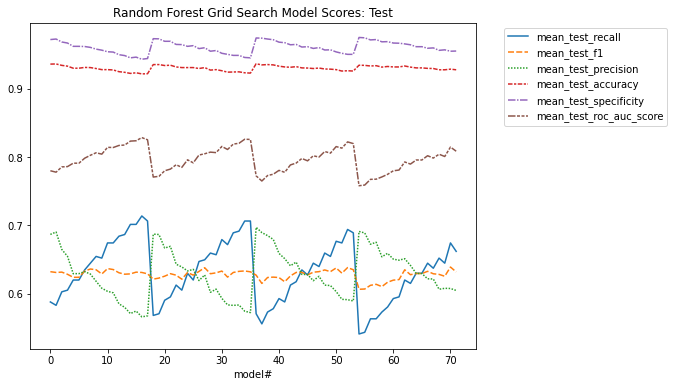

In [624]:
# Test Scoring Plot
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_fine_scores_test)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.xlim(0,20)
# plt.xticks(np.arange(0,21,1))
plt.xlabel('model#')
plt.title('Random Forest Grid Search Model Scores: Test')
# plt.xlim(15,25)
# plt.xticks(range(15,26,1))
# plt.savefig('../output/rf_grid_fine_scores_test1_zoom.png')
# plt.savefig('../output/rf_grid_fine_scores_test1_zoom.png')

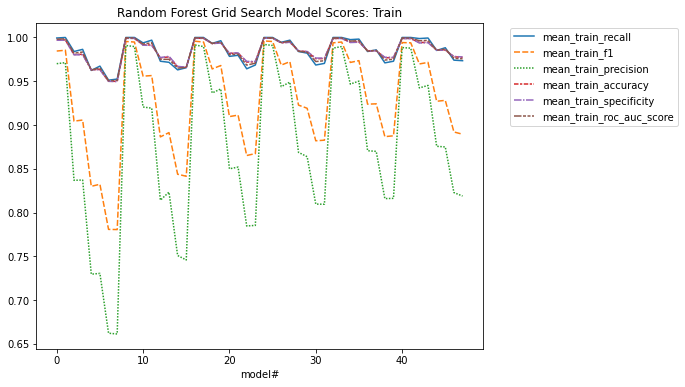

In [529]:
# Train Scoring Plot
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_train)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xlabel('model#')
plt.title('Random Forest Grid Search Model Scores: Train')
# plt.savefig('../output/rf_grid_fine_scores_train1.png')

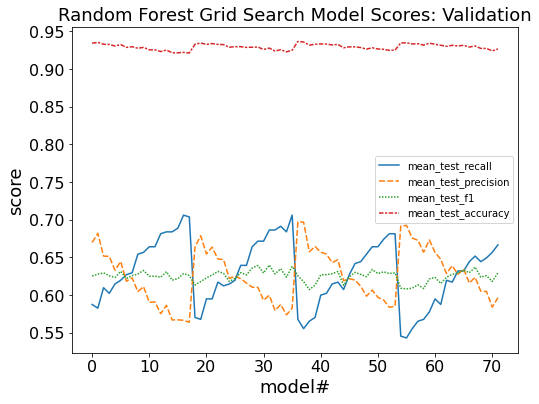

In [933]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_fine_scores[['mean_test_recall','mean_test_precision','mean_test_f1',
                                   'mean_test_accuracy']])
plt.legend( loc=5) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Validation', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('../output/rf_grid_fine_search_scores_validation.png', bbox_inches='tight')
plt.savefig('../output/rf_grid_fine_search_scores_dropmedian_validation.png', bbox_inches='tight')

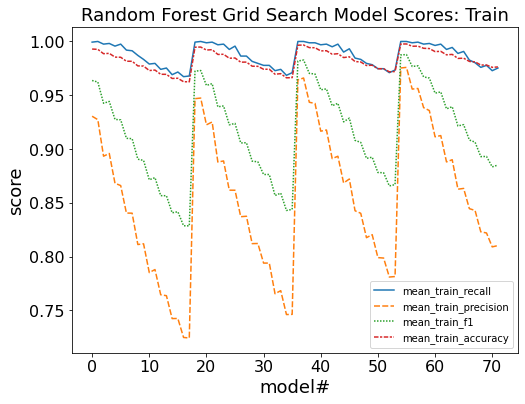

In [901]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_fine_scores[['mean_train_recall','mean_train_precision', 'mean_train_f1','mean_train_accuracy']])
plt.legend(loc=4) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Train', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('../output/rf_grid_fine_search_scores_train.png', bbox_inches='tight')

In [934]:
# choose best model based on a score: favor sensitivity
# want to maximize false positive over all positives (low precision), minimize false negative (high recall)
best_row = rf_grid_fine_scores.mean_test_recall.idxmax()
worst_row = rf_grid_fine_scores.mean_test_recall.idxmin()
print('best RF row number', best_row)
print('worst RF row number', worst_row)
print('best RF fine', rf_grid_fine_scores.params[best_row])
display(rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('mean_test')]].iloc[[best_row,]])
display(rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('mean_train')]].iloc[[best_row,]])


best RF row number 16
worst RF row number 55
best RF fine {'max_features': 1, 'min_samples_split': 14, 'n_estimators': 200}


,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy,mean_test_specificity,mean_test_roc_auc_score
16,0.525926,0.606345,0.717496,0.936228,0.978586,0.752256


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
16,1.0,0.994782,0.989621,0.999018,0.998917,0.999458


In [554]:
rf_grid_fine_scores[['mean_test_recall', 'mean_test_precision']].iloc[16:18]

,mean_test_recall,mean_test_precision
16,0.713580,0.565811
17,0.706173,0.567264


In [1031]:
# drop DurationMedianIP
df_dum_drop = df_dum.drop(['DurationMedianIP'], axis=1)
x = df_dum_drop.drop(['PotentialFraud'], axis = 1)
y = df_dum_drop.PotentialFraud
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=4, stratify=y)

rf_best_fine = RandomForestClassifier(random_state=4, oob_score=True, class_weight='balanced', 
                                  max_features=1, min_samples_split=14, n_estimators=200)
rf_best_fine.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=4, verbose=0,
                       warm_start=False)

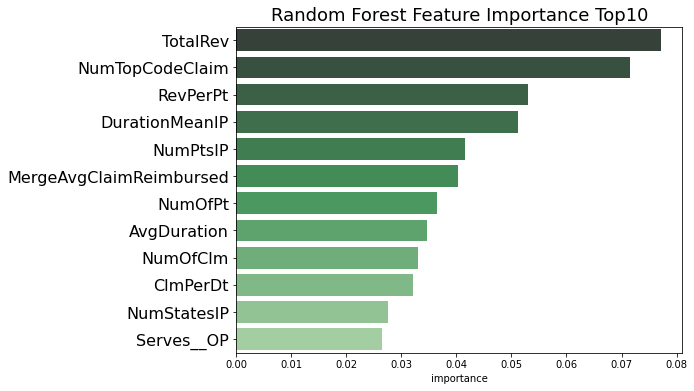

In [1032]:
rf_feature_imp_fine = pd.DataFrame(data = rf_best_fine.feature_importances_, index=xtrain.columns, columns=['importance']).sort_values(by = 'importance', ascending=False)
# rf_feature_imp.plot(kind = 'bar')
rf_feature_imp_fine.to_csv('../output/rf_final_fine_features_importance.csv')
plt.figure(figsize=(8,6))
sns.barplot(y = rf_feature_imp_fine.index[:12], x = 'importance', 
            data = rf_feature_imp_fine[:12],palette=sns.color_palette('Greens_d', n_colors=12))
plt.title('Random Forest Feature Importance Top10', fontsize=18)
plt.yticks(fontsize = 16)
plt.savefig('../output/rf_final_fine_feature_importance_green_2.png', bbox_inches='tight')
# plt.savefig('../output/rf_final_fine_feature_importance_dropmedian_green_2.png', bbox_inches='tight')

In [1051]:
# keep all col
x = df_dum.drop(['PotentialFraud'], axis = 1)
y = df_dum.PotentialFraud
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=4, stratify=y)

rf_best_fine = RandomForestClassifier(oob_score=True, class_weight='balanced', 
                                  max_features=2, min_samples_split=20, n_estimators=500) #min_samples_leaf=10
rf_best_fine.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

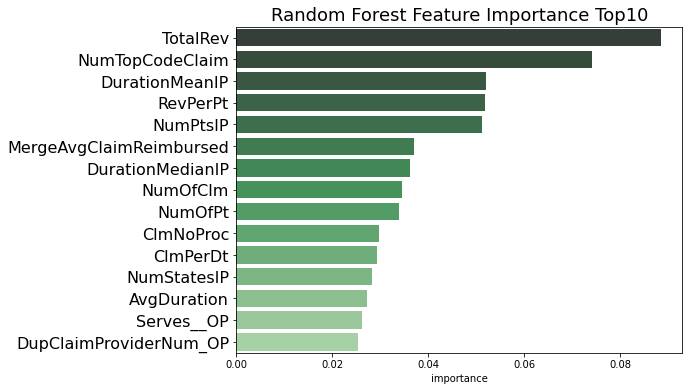

In [1052]:
rf_feature_imp_fine = pd.DataFrame(data = rf_best_fine.feature_importances_, index=xtrain.columns, columns=['importance']).sort_values(by = 'importance', ascending=False)
# rf_feature_imp.plot(kind = 'bar')
rf_feature_imp_fine.to_csv('../output/rf_final_fine_features_importance.csv')
plt.figure(figsize=(8,6))
sns.barplot(y = rf_feature_imp_fine.index[:15], x = 'importance', 
            data = rf_feature_imp_fine[:15],palette=sns.color_palette('Greens_d', n_colors=15))
plt.title('Random Forest Feature Importance Top10', fontsize=18)
plt.yticks(fontsize = 16)
# plt.savefig('../output/rf_final_fine_feature_importance_green_2.png', bbox_inches='tight')
plt.savefig('../output/rf_final_fine_feature_importance_dropmedian_green_2.png', bbox_inches='tight')

In [942]:
pd.options.display.float_format = '{:.4f}'.format

,0,1
0,3713,210
1,40,365


              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3923
           1       0.63      0.90      0.74       405

    accuracy                           0.94      4328
   macro avg       0.81      0.92      0.86      4328
weighted avg       0.96      0.94      0.95      4328



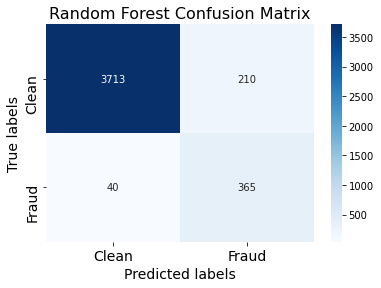

In [1070]:
# confusion matrix
ypred = rf_best_fine.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

# recall = recall_score(ytrain.array, ypred, average='binary', pos_label=0) # sensitivity
# print('recall:', round(recall, ndigits=5))
# precision = rf_grid.best_estimator_.score(xtrain, ytrain) # precision
# print('precision:', round(precision, ndigits=4))
# accuracy = accuracy_score(ytrain.array, ypred) # accuracy
# print('accuracy', round(accuracy, 4))

print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Random Forest Confusion Matrix', fontsize=16)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
plt.savefig('../output/rf_fine_cm_heatmap_1.png')

In [ ]:
# sklearn.feature_selection import selectFromModel
# compute_class_weight

## EDA feature

In [1074]:
df_dum.columns

Index(['PotentialFraud', 'DurationMedianIP', 'DurationMeanIP', 'DurationMedianOP', 'DurationMeanOP', 'ChronCondsMedian', 'ChronCondsMean', 'ChronConsMode', 'PtAgeMedian', 'PtAgeMean', 'NumPtsIP', 'NumPtsOP', 'NumStatesIP', 'NumStatesOP', 'SharePhysician', 'MergeAvgClaimReimbursed', 'NumTopCodeClaim', 'DupClaimNum_IP', 'DupClaimRatio_IP', 'DupClaim_IP', 'DupClaimStatesNum_IP', 'DupClaimMultiState_IP', 'DupClaimProviderNum_IP', 'DupClaimMultiProvider_IP', 'DupClaimStartDtNum_IP', 'DupClaimMultiStartDt_IP', 'DupClaimNum_OP', 'DupClaimRatio_OP', 'DupClaim_OP', 'DupClaimStatesNum_OP', 'DupClaimMultiState_OP', 'DupClaimProviderNum_OP', 'DupClaimMultiProvider_OP', 'DupClaimStartDtNum_OP', 'DupClaimMultiStartDt_OP', 'AvgDuration', 'NumOfPt', 'NumOfClm', 'ClmPerPt', 'TotalRev', 'RevPerPt', 'ClmNoPhy', 'ClmAllPhy', 'ClmNoProc', 'ClmPerDt', 'Serves__IP', 'Serves__OP'], dtype='object')

Text(0.5, 1.0, 'DupClaimRatio')

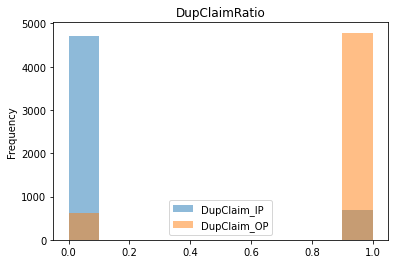

In [1075]:
df_dum.DupClaim_IP.plot.hist(alpha = 0.5)
df_dum.DupClaim_OP.plot.hist(alpha = 0.5)
plt.legend()
plt.title('DupClaimRatio')
# plt.savefig('../output/flag_dupclaimratio.png')

In [1115]:
from statsmodels.graphics.mosaicplot import mosaic
# mosaic plot
df_dum[['DupClaim_IP', 'DupClaim_OP']].head()
a = pd.DataFrame(df_dum.DupClaim_IP.value_counts()).reset_index().rename(columns={'index':"PotentialFraud"})
b = pd.DataFrame(df_dum.DupClaim_OP.value_counts()).reset_index().rename(columns={'index':"PotentialFraud"})
display(a)
display(b)
c = a.merge(b, how='inner', on='PotentialFraud')
c['PotentialFraud'] = np.where(c['PotentialFraud'] == 0, 'No', 'Yes')
c.set_index('PotentialFraud', inplace = True)
display(c)
d = c.to_dict()

,PotentialFraud,DupClaim_IP
0,0,4715
1,1,695


,PotentialFraud,DupClaim_OP
0,1,4786
1,0,624


,DupClaim_IP,DupClaim_OP
PotentialFraud,,
No,4715,624
Yes,695,4786


{'DupClaim_IP': {'No': 4715, 'Yes': 695}, 'DupClaim_OP': {'No': 624, 'Yes': 4786}}


(<Figure size 432x288 with 3 Axes>,
 OrderedDict([(('4715', '624'),
               (0.0, 0.0, 0.49751243781094534, 0.9966777408637874)),
              (('4715', '4786'), (0.0, 1.0, 0.49751243781094534, 0.0)),
              (('695', '624'),
               (0.5024875621890548, 0.0, 0.49751243781094534, 0.0)),
              (('695', '4786'),
               (0.5024875621890548,
                0.0033222591362126247,
                0.49751243781094534,
                0.9966777408637874))]))

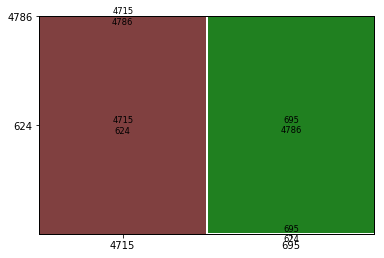

In [1120]:
print(d)
DupClaim_IP = [4715, 695]
DupClaim_OP = [624,4786]
data = pd.DataFrame({'IP': DupClaim_IP, 'OP': DupClaim_OP})
mosaic(data, ['IP', 'OP'])

(<Figure size 432x288 with 1 Axes>,
 OrderedDict([(('No',), (0.0, 0.0, 0.8629051444885709, 1.0)),
              (('Yes',), (0.8728061345875808, 0.0, 0.1271938654124192, 1.0))]))

<Figure size 72x432 with 0 Axes>

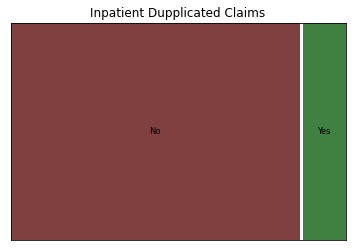

In [1118]:
plt.figure(figsize=(1,6))
mosaic(d['DupClaim_IP'], title = 'Inpatient Dupplicated Claims', gap=0.01, axes_label = False)
# mosaic(d['DupClaim_OP'], title = 'Outpatient Dupplicated Claims', gap=0.01, axes_label = False)

### K means clustering